# Policy iteration and value iteration

In this notebook, you will implement different dynamic programming approaches described in [Sutton and Barto's book, Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html). A grid ```World``` class and policy iteration has been implemented. Feel free to add more actions, rewards and/or terminals, or to modify the code to suit your needs.

## Imports

In [154]:
import numpy as np
import time
from tqdm import tqdm
from numpy._typing import NDArray
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

pd.options.display.float_format = "{:,.3f}".format

### `World` class and globals

The `World` is a grid represented as a two-dimensional array of characters where each character can represent free space, an obstacle, or a terminal. Each non-obstacle cell is associated with a reward that an agent gets for moving to that cell (can be 0). The size of the world is _width_ $\times$ _height_ characters.

A _state_ is a tuple $(x,y)$.

An empty world is created in the ```__init__``` method. Obstacles, rewards and terminals can then be added with ```add_obstacle``` and ```add_reward```.

To calculate the next state of an agent (that is, an agent is in some state $s = (x,y)$ and performs and action, $a$), ```get_next_state()```should be called. It will only be relevant to call this function later on, when we do learning based on interaction with the environment and where an agent actually has to move.

For now, you will only need the probabilities over next states given an action, $a$, that is, call ```get_state_transition_probabilities```.

In [155]:
# Globals:
ACTIONS = ("up", "down", "left", "right")

# Rewards, terminals and obstacles are characters:
REWARDS = {" ": 0, ".": 0.1, "+": 10, "-": -10}
TERMINALS = ("+", "-")  # Note a terminal should also have a reward assigned
OBSTACLES = "#"

# Discount factor
gamma = 0.5

# The probability of a random move:
rand_move_probability = 0


class World:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        # Create an empty world where the agent can move to all cells
        self.grid = np.full((width, height), " ", dtype="U1")

    def add_obstacle(self, start_x, start_y, end_x=None, end_y=None):
        """
        Create an obstacle in either a single cell or rectangle.
        """
        if end_x is None:
            end_x = start_x
        if end_y is None:
            end_y = start_y

        self.grid[start_x : end_x + 1, start_y : end_y + 1] = OBSTACLES[0]

    def add_reward(self, x, y, reward):
        assert reward in REWARDS, f"{reward} not in {REWARDS}"
        self.grid[x, y] = reward

    def add_terminal(self, x, y, terminal):
        assert terminal in TERMINALS, f"{terminal} not in {TERMINALS}"
        self.grid[x, y] = terminal

    def is_obstacle(self, x, y):
        if x < 0 or x >= self.width or y < 0 or y >= self.height:
            return True
        else:
            return self.grid[x, y] in OBSTACLES

    def is_terminal(self, x, y):
        return self.grid[x, y] in TERMINALS

    def get_reward(self, x, y):
        """
        Return the reward associated with a given location
        """
        return REWARDS[self.grid[x, y]]

    def get_next_state(self, current_state, action, deterministic=False):
        """
        Get the next state given a current state and an action. Can eiter be
        deterministic (no random actions) or non-deterministic,
        where rand_move_probability determines the probability of ignoring the
        action and performing a random move.
        """
        assert action in ACTIONS, f"Unknown acion {action} must be one of {ACTIONS}"

        x, y = current_state

        # If our current state is a terminal, there is no next state
        if self.grid[x, y] in TERMINALS:
            return None

        # Check of a random action should be performed:
        if not deterministic and np.random.rand() < rand_move_probability:
            action = np.random.choice(ACTIONS)

        if action == "up":
            y -= 1
        elif action == "down":
            y += 1
        elif action == "left":
            x -= 1
        elif action == "right":
            x += 1

        # If the next state is an obstacle, stay in the current state
        return (x, y) if not self.is_obstacle(x, y) else current_state

    def get_state_transition_probabilities(self, current_state, action):
        """
        Returns a dict where key = state and value = probability given current state
        is (x,y) and "action" is performed.
        """
        assert action in ACTIONS, f"Unknown acion {action} must be one of {ACTIONS}"

        x, y = current_state
        if self.is_terminal(x, y):
            return {}

        next_state_probabilities = {}
        # Since there is rand_move_probability of performing any action, we have to
        # go through all actions and check what their next state would be:
        for a in ACTIONS:
            next_state = self.get_next_state((x, y), a, deterministic=True)
            if a == action:
                prob = 1 - rand_move_probability + rand_move_probability / len(ACTIONS)
            else:
                prob = rand_move_probability / len(ACTIONS)

            if next_state in next_state_probabilities:
                next_state_probabilities[next_state] += prob
            else:
                if prob > 0.0:
                    next_state_probabilities[next_state] = prob

        return next_state_probabilities

## Basic examples: World, obstacles, rewards and terminals

Below are some examples to illustrate how the ```World``` class works.

First, we create a 4x4 world:

In [156]:
world = World(4, 4)

# Note, that we have to transpose the 2D array (.T) for (x,y)
# to match the convention when displayed
print(world.grid.T)

[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]


Obstacles and terminals are all represented as single characters:

In [157]:
print(f"Obstacles: {OBSTACLES}")
print(f"Terminals: {TERMINALS}")

Obstacles: #
Terminals: ('+', '-')


Rewards are also represented as characters in the world, but they have an associated value (note that defining a value for an empty space "  " is equivalent to the agent receiving that reward each time a move is made):

In [158]:
print(f"Rewards: {REWARDS}")

Rewards: {' ': 0, '.': 0.1, '+': 10, '-': -10}


To assign rewards to terminal states, just use the same character in the `REWARDS` dict and in the `TERMINALS` tuple.

In [159]:
for t in TERMINALS:
    print(f"Terminal {t} has reward {REWARDS[t]}")

world.add_terminal(0, 0, "+")
world.add_terminal(3, 3, "-")

print(world.grid.T)

# An alternative way of displaying the world using pandas:
display(pd.DataFrame(world.grid.T))

Terminal + has reward 10
Terminal - has reward -10
[['+' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']]


,0,1,2,3
0,+,,,
1,,,,
2,,,,
3,,,,-


## Policies ($\pi$)

Recall that a policy, $\pi(a|s) = \Pr(A_t = a | S_t = s)$, maps states to action probabilities. In the code below, we let policies return the probabilities of each possible action given a state. States are $(x, y)$ coordinates and the policy must return action probabilities as a dict where the action is the ```key``` and the corresponding ```value``` is the probability of taking that action in the given state. Deterministic policies, for instance, return a dict with only one entry (e.g. ```{ "up": 1 } ``` if the action for the current state is ```up```).

A random policy can be defined as follows:

In [160]:
def equiprobable_random_policy(x, y):
    return {k: 1 / len(ACTIONS) for k in ACTIONS}


# Example (since the action probabilities do not depend on the state in this
# basic policy, we can just call it for state (0, 0)):
print(equiprobable_random_policy(0, 0))

{'up': 0.25, 'down': 0.25, 'left': 0.25, 'right': 0.25}


## Iterative policy evaluation

Iterative policy evaluation takes a ```World```, a discount factor, $\gamma$ (```gamma```, defined above in the ```World``` code cell), a policy, $\pi$, and a threshold, $\theta$ (```theta```), that determines when to stop the iteration. You can also specify a maximum number of iterations which can be useful for debugging using the ```max_iterations``` argument.

**IMPORTANT:** Remember that in iterative policy evaluation, we just learn state values ($V_\pi$) given a policy $\pi$. We are **not** trying to learn a policy.

(see page 74-75 of [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html) for an explanation and the algorithm)

In [161]:
def iterative_policy_evaluation(world, policy, theta=1e-5, max_iterations=1e3):
    # Our initial estimates for all states in the world is 0:
    V = np.full((world.width, world.height), 0.0)

    while True:
        # delta keeps track of the largest change in one iteration, so we set it to
        # 0 at the start of each iteration:
        delta = 0

        # Loop over all states (x,y)
        for y in range(world.height):
            for x in range(world.width):
                if not world.is_obstacle(x, y):
                    # Get action probabilities for the current state:
                    actions = policy(x, y)

                    # v is the new estimate that will be updated in the loop:
                    v = 0

                    # loop over all actions that our policy says that we can perform
                    # in the current state:
                    for action, action_prob in actions.items():
                        # For each action, get state transition probabilities and
                        # accumulate in v rewards weighted with action and state transition
                        # probabilities:
                        for (
                            xi,
                            yi,
                        ), state_prob in world.get_state_transition_probabilities(
                            (x, y), action
                        ).items():
                            v += (
                                action_prob
                                * state_prob
                                * (world.get_reward(xi, yi) + gamma * V[xi, yi])
                            )

                    # update delta (largest change in estimate so far)
                    delta = max(delta, abs(v - V[x, y]))
                    V[x, y] = v

        # check if current state value estimates are close enought to end:
        if delta <= theta:
            break

        max_iterations -= 1
        if max_iterations == 0:
            break

    # Return the state value estimates
    return V

## Implementation of Example 4.1 from the book

Below, you can see the implementation of Example 4.1 on page 76 in the book [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html)

In [162]:
# World is 4x4
world = World(4, 4)

# Rewards are -1 for each move (including when hitting a terminal state, "+"):
REWARDS = {" ": -1, "+": -1}


# Add terminal states in two corners
world.add_terminal(0, 0, "+")
world.add_terminal(3, 3, "+")

print(world.grid.T)

[['+' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']]


In [163]:
V = iterative_policy_evaluation(world, equiprobable_random_policy)

display(pd.DataFrame(V.T))

,0,1,2,3
0,0.000,-1.695,-1.949,-1.983
1,-1.695,-1.915,-1.966,-1.949
2,-1.949,-1.966,-1.915,-1.695
3,-1.983,-1.949,-1.695,0.000


## Exercise - policy and discount factor

Experiment with example 4.1: what effect does it have to change the policy, e.g. so that an agent always goes left or always goes right? What effect does it have on state values to change the value of the discount factor (```gamma```)?

In [164]:
# World is 4x4
world = World(4, 4)

# Rewards are -1 for each move (including when hitting a terminal state, "+"):
REWARDS = {" ": -1, "+": -1}


# Add terminal states in two corners
world.add_terminal(0, 0, "+")
world.add_terminal(3, 3, "+")

print(world.grid.T)

[['+' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']]


In [165]:
def always_right_policy(x, y):
    return {k: 1 if k == "right" else 0 for k in ACTIONS}


print(always_right_policy(0, 0))
# Set gamma to converge
V = iterative_policy_evaluation(world, always_right_policy)

display(pd.DataFrame(V.T))

{'up': 0, 'down': 0, 'left': 0, 'right': 1}


,0,1,2,3
0,0.000,-2.000,-2.000,-2.000
1,-2.000,-2.000,-2.000,-2.000
2,-2.000,-2.000,-2.000,-2.000
3,-1.750,-1.500,-1.000,0.000


Try to write a policy that is deterministic, but where the action performed differs between states. You can implement it as a two-dimensional array with the dimensions corresponding to the world dimensions and have each entry be an action for the corresponding state.

In [166]:
def deterministic_policy(x, y):
    if y == 0:
        return {k: 1 if k == "left" else 0 for k in ACTIONS}
    elif y == 1:
        return {k: 1 if k == "up" else 0 for k in ACTIONS}
    elif y == 2:
        return {k: 1 if k == "down" else 0 for k in ACTIONS}
    elif y == 3:
        return {k: 1 if k == "right" else 0 for k in ACTIONS}
    else:
        assert 0, f"Y is out of bounds: {y}"


V = iterative_policy_evaluation(world, deterministic_policy)

display(pd.DataFrame(V.T))

,0,1,2,3
0,0.000,-1.000,-1.500,-1.750
1,-1.000,-1.500,-1.750,-1.875
2,-1.875,-1.750,-1.500,-1.000
3,-1.750,-1.500,-1.000,0.000


## Exercise - stochasticity
You can adjust the degree of stochasticity in the environment by setting the global variable ```rand_move_probability``` (the probability of the world ignoring an action and performing a random move instead). What effect does stochasticity have on the state-value estimates?

In [167]:
rand_move_probability = 0.5

V = iterative_policy_evaluation(world, deterministic_policy)

display(pd.DataFrame(V.T))

,0,1,2,3
0,0.000,-1.298,-1.752,-1.905
1,-1.309,-1.723,-1.883,-1.915
2,-1.915,-1.883,-1.723,-1.309
3,-1.905,-1.752,-1.298,0.000


## Exercise - robot, cake and mouse trap

Implement a robot, cake and mouse trap example and compute state value estimates under different policies (equiprobable, always right, always right:50% or up:50%) with and without stochasticity.

In [168]:
rand_move_probability = 0
REWARDS = {" ": 0, ".": -0.1, "+": 10, "-": -10}


world = World(4, 3)
world.add_terminal(3, 0, "+")  # Cake
world.add_terminal(3, 1, "-")  # Mouse trap

world.add_obstacle(1, 1)


def always_up_right_policy(x, y):
    return {k: 0.5 if (k == "right" or k == "up") else 0 for k in ACTIONS}


for prob in [0, 0.25, 0.5]:
    rand_move_probability = prob
    V1 = iterative_policy_evaluation(world, equiprobable_random_policy)
    V2 = iterative_policy_evaluation(world, always_right_policy)
    V3 = iterative_policy_evaluation(world, always_up_right_policy)

    print("\n" + "_" * 30)
    print(f"rand_move_probability: {prob}")
    print("_" * 30)
    display(pd.DataFrame(V1.T), pd.DataFrame(V2.T), pd.DataFrame(V3.T))


______________________________
rand_move_probability: 0
______________________________


,0,1,2,3
0,0.074,0.437,2.545,0.000
1,0.008,0.000,-2.621,0.000
2,-0.024,-0.153,-0.894,-3.482


,0,1,2,3
0,2.500,5.000,10.000,0.000
1,0.000,0.000,-10.000,0.000
2,0.000,0.000,0.000,0.000


,0,1,2,3
0,0.741,2.222,6.667,0.000
1,0.247,0.000,-3.333,0.000
2,-0.147,-0.833,-2.500,-6.667



______________________________
rand_move_probability: 0.25
______________________________


,0,1,2,3
0,0.074,0.437,2.545,0.000
1,0.008,0.000,-2.621,0.000
2,-0.024,-0.153,-0.894,-3.482


,0,1,2,3
0,1.573,3.624,8.241,0.000
1,0.080,0.000,-8.146,0.000
2,-0.142,-0.333,-0.757,-1.153


,0,1,2,3
0,0.482,1.634,5.532,0.000
1,0.136,0.000,-3.335,0.000
2,-0.113,-0.620,-2.110,-5.921



______________________________
rand_move_probability: 0.5
______________________________


,0,1,2,3
0,0.074,0.437,2.545,0.000
1,0.008,0.000,-2.621,0.000
2,-0.024,-0.153,-0.894,-3.482


,0,1,2,3
0,0.843,2.347,6.402,0.000
1,0.070,0.000,-6.317,0.000
2,-0.146,-0.423,-1.154,-2.115


,0,1,2,3
0,0.290,1.138,4.455,0.000
1,0.066,0.000,-3.222,0.000
2,-0.078,-0.432,-1.702,-5.142


## Exercise - action-value function

Based on a set of calculated state values, try to implement an action value function, that is $q_\pi(s, a)$ (if in doubt, see page 78 in [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html)). Note: you have to use the ```get_state_transition_probabilities()``` method on ```World``` to be able to handle stochastic environments where performing ```a``` does not lead to a deterministic outcome.

In [169]:
def action_value(world: World, V, state, action):
    q = 0
    for next_state, prob in world.get_state_transition_probabilities(
        state, action
    ).items():
        nx, ny = next_state
        q += prob * (world.get_reward(nx, ny) + gamma * V[nx, ny])
    return q

In [170]:
# Testing the action
world = World(4, 4)
world.add_terminal(0, 0, "+")
world.add_terminal(3, 3, "-")
V = iterative_policy_evaluation(world, equiprobable_random_policy)
display(pd.DataFrame(V.T))
for a in ACTIONS:
    print(f"Action value for {a}:")
    print(action_value(world, V, (1, 1), a))

,0,1,2,3
0,0.000,3.027,0.432,0.000
1,3.027,0.757,0.000,-0.432
2,0.432,0.000,-0.757,-3.027
3,0.000,-0.432,-3.027,0.000


Action value for up:
1.1351365620144696
Action value for down:
0.37837932567849514
Action value for left:
1.1351365620144696
Action value for right:
0.3783793256784951


## Exercise - policy iteration

You are now ready to implement policy iteration. That is, first estimate state values under a given policy, then improve the policy based on those estimates and action values, estimate state values again, and so on. See page 80 in [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html)

You will need an explicit representation of your policy that you can easily change.

Test your implementation and print out the policies found.

In [171]:
rand_move_probability = 0.5
REWARDS = {" ": 0, ".": -0.1, "+": 10, "-": -10}
world = World(7, 7)
world.add_terminal(0, 0, "+")
world.add_terminal(5, 6, "-")
world.add_obstacle(3, 1)
world.add_obstacle(3, 5)

# Start with a right policy everywhere
polit_policy = np.full((world.width, world.height), "right", dtype="U5")


def policy_iteration_policy(x, y):
    return {k: 1 if k == polit_policy[x, y] else 0 for k in ACTIONS}


V = iterative_policy_evaluation(world, policy_iteration_policy)

while True:
    policy_stable = True
    V = iterative_policy_evaluation(world, policy_iteration_policy)

    for y in range(world.height):
        for x in range(world.width):
            if not world.is_obstacle(x, y):
                old_action = polit_policy[x, y]
                best_action = None
                best_value = -np.inf
                for a in ACTIONS:
                    q = action_value(world, V, (x, y), a)
                    if q > best_value:
                        best_value = q
                        best_action = a
                polit_policy[x, y] = best_action
                if old_action != best_action:
                    policy_stable = False
    if policy_stable:
        break

# Display the world
display(pd.DataFrame(world.grid.T))

# Display the final policy
display(pd.DataFrame(polit_policy.T))

# Display the final state values
display(pd.DataFrame(V.T))

,0,1,2,3,4,5,6
0,+,,,,,,
1,,,,#,,,
2,,,,,,,
3,,,,,,,
4,,,,,,,
5,,,,#,,,
6,,,,,,-,


,0,1,2,3,4,5,6
0,up,left,left,left,left,left,left
1,up,up,left,right,up,left,left
2,up,up,up,left,left,left,left
3,up,up,up,left,left,left,up
4,up,up,up,left,left,up,up
5,up,up,up,right,up,up,up
6,up,up,up,left,left,up,up


,0,1,2,3,4,5,6
0,0.000,7.016,2.474,0.906,0.317,0.111,0.041
1,7.016,2.768,1.117,0.000,0.112,0.045,0.018
2,2.468,1.072,0.436,0.154,0.058,0.022,0.009
3,0.871,0.410,0.170,0.066,0.024,0.004,0.002
4,0.308,0.155,0.066,0.026,-0.007,-0.081,-0.018
5,0.109,0.058,0.026,0.000,-0.181,-1.299,-0.192
6,0.041,0.022,0.004,-0.097,-1.378,0.000,-1.497


## Exercise - value iteration

Value iteration is much more effecient than policy iteration. Implement value iteration below. See page 83 in [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html).

Test your implementation and display the policies found (i.e., a grid with the perferred action in each cell).

In [172]:
rand_move_probability = 0.5
REWARDS = {" ": 0, ".": -0.1, "+": 10, "-": -10}
world = World(7, 7)
world.add_terminal(0, 0, "+")
world.add_terminal(5, 6, "-")
world.add_obstacle(3, 1)
world.add_obstacle(3, 5)

# Start with a right policy everywhere
valit_policy = np.full((world.width, world.height), "right", dtype="U5")


def value_iteration_policy(x, y):
    return {k: 1 if k == valit_policy[x, y] else 0 for k in ACTIONS}


# Start with initial value estimates
V = iterative_policy_evaluation(world, value_iteration_policy)

theta = 1e-5
while True:
    delta = 0
    for y in range(world.height):
        for x in range(world.width):
            if not world.is_obstacle(x, y):
                old_value = V[x, y]
                best_value = -np.inf
                best_action = None
                for a in ACTIONS:
                    q = action_value(world, V, (x, y), a)
                    if q > best_value:
                        best_action = a
                        best_value = q
                V[x, y] = best_value
                valit_policy[x, y] = best_action
                delta = max(delta, abs(old_value - V[x, y]))

    if delta <= theta:
        break

# Display the world
display(pd.DataFrame(world.grid.T))

# Display the final policy
display(pd.DataFrame(valit_policy.T))

# Display the final state values
display(pd.DataFrame(V.T))

,0,1,2,3,4,5,6
0,+,,,,,,
1,,,,#,,,
2,,,,,,,
3,,,,,,,
4,,,,,,,
5,,,,#,,,
6,,,,,,-,


,0,1,2,3,4,5,6
0,up,left,left,left,left,left,left
1,up,up,left,right,up,left,left
2,up,up,up,left,left,left,left
3,up,up,up,left,left,left,up
4,up,up,up,left,left,up,up
5,up,up,up,right,up,up,up
6,up,up,up,left,left,up,up


,0,1,2,3,4,5,6
0,0.000,7.016,2.474,0.906,0.317,0.111,0.041
1,7.016,2.768,1.117,0.000,0.112,0.045,0.018
2,2.468,1.072,0.436,0.154,0.058,0.022,0.009
3,0.871,0.410,0.170,0.066,0.024,0.004,0.002
4,0.308,0.155,0.066,0.026,-0.007,-0.081,-0.018
5,0.109,0.058,0.026,0.000,-0.181,-1.299,-0.192
6,0.041,0.022,0.004,-0.097,-1.378,0.000,-1.497


# Perf test

REWARDS = {" ": 0, ".": -0.1, "+": 10, "-": -10}
world = World(20, 20)
world.add_terminal(19, 19, "+")
world.add_terminal(5, 5, "-")
world.add_obstacle(10, 10)
world.add_obstacle(12, 16)

Display the world
display(pd.DataFrame(world.grid.T))

### Policy evaluation
Start with a right policy everywhere
valit_times = []
polit_times = []

for i in tqdm(range(100)):
    polit_policy = np.full((world.width, world.height), "right", dtype="U5")

    def policy_iteration_policy(x, y):
        return {k: 1 if k == polit_policy[x, y] else 0 for k in ACTIONS}

    polit_start = time.perf_counter()
    V = iterative_policy_evaluation(world, policy_iteration_policy)
    while True:
        policy_stable = True
        V = iterative_policy_evaluation(world, policy_iteration_policy)

        for y in range(world.height):
            for x in range(world.width):
                if not world.is_obstacle(x, y):
                    old_action = polit_policy[x, y]
                    best_action = None
                    best_value = -np.inf
                    for a in ACTIONS:
                        q = action_value(world, V, (x, y), a)
                        if q > best_value:
                            best_value = q
                            best_action = a
                    polit_policy[x, y] = best_action
                    if old_action != best_action:
                        policy_stable = False
        if policy_stable:
            break
    polit_end = time.perf_counter()

    ################################

    #### Value evaluation
    # Start with a right policy everywhere
    valit_policy = np.full((world.width, world.height), "right", dtype="U5")

    def value_iteration_policy(x, y):
        return {k: 1 if k == valit_policy[x, y] else 0 for k in ACTIONS}

    valit_start = time.perf_counter()
    # Start with initial value estimates
    V = iterative_policy_evaluation(world, value_iteration_policy)

    theta = 1e-5
    while True:
        delta = 0
        for y in range(world.height):
            for x in range(world.width):
                if not world.is_obstacle(x, y):
                    old_value = V[x, y]
                    best_value = -np.inf
                    best_action = None
                    for a in ACTIONS:
                        q = action_value(world, V, (x, y), a)
                        if q > best_value:
                            best_action = a
                            best_value = q
                    V[x, y] = best_value
                    valit_policy[x, y] = best_action
                    delta = max(delta, abs(old_value - V[x, y]))
        if delta <= theta:
            break
    valit_end = time.perf_counter()

    # # Display the final policy
    # display(pd.DataFrame(polit_policy.T))
    #
    # # Display the final policy
    # display(pd.DataFrame(valit_policy.T))

    polit_times.append(polit_end - polit_start)
    valit_times.append(valit_end - valit_start)
print(polit_times)
print(valit_times)

3.378859354619988
0.7616042933299831
4.436502504268338


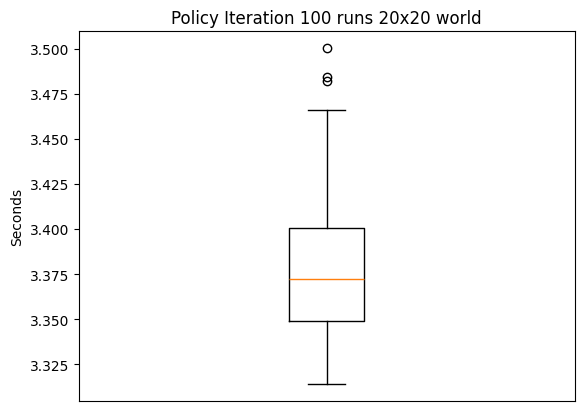

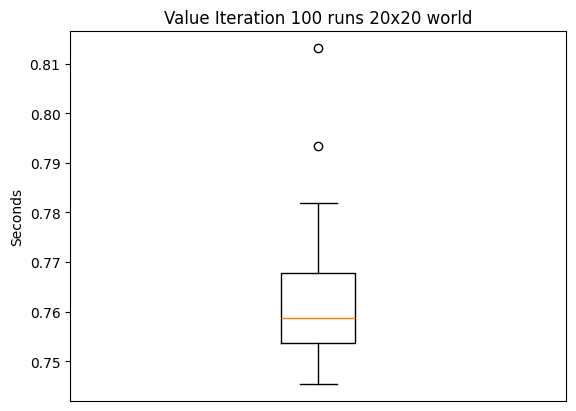

In [173]:
polit_times_avg = np.average(polit_times)
valit_times_avg = np.average(valit_times)
print(polit_times_avg)
print(valit_times_avg)
print(polit_times_avg / valit_times_avg)


plt.boxplot(polit_times)
plt.title("Policy Iteration 100 runs 20x20 world")
plt.ylabel("Seconds")
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

plt.boxplot(valit_times)
plt.title("Value Iteration 100 runs 20x20 world")
plt.ylabel("Seconds")
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()